## Image segmentation with CamVid

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [ ]:
path = Path('./data/camvid-tiramisu')

In [ ]:
path.ls()

[PosixPath('data/camvid-tiramisu/valannot'),
 PosixPath('data/camvid-tiramisu/test'),
 PosixPath('data/camvid-tiramisu/val'),
 PosixPath('data/camvid-tiramisu/val.txt'),
 PosixPath('data/camvid-tiramisu/trainannot'),
 PosixPath('data/camvid-tiramisu/testannot'),
 PosixPath('data/camvid-tiramisu/train'),
 PosixPath('data/camvid-tiramisu/test.txt'),
 PosixPath('data/camvid-tiramisu/train.txt'),
 PosixPath('data/camvid-tiramisu/models')]

## Data

In [ ]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('data/camvid-tiramisu/val/0016E5_08065.png'),
 PosixPath('data/camvid-tiramisu/val/0016E5_07989.png'),
 PosixPath('data/camvid-tiramisu/val/0016E5_08041.png')]

In [ ]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('data/camvid-tiramisu/valannot/0016E5_08065.png'),
 PosixPath('data/camvid-tiramisu/valannot/0016E5_07989.png'),
 PosixPath('data/camvid-tiramisu/valannot/0016E5_08041.png')]

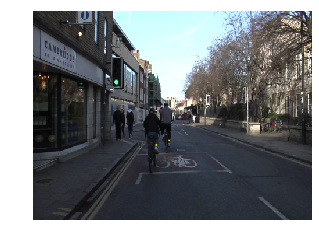

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

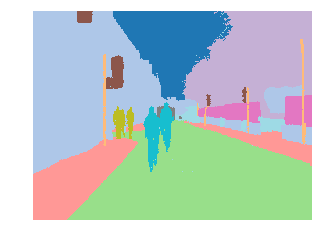

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[ 1,  1,  1,  ...,  5,  5,  5],
          [ 1,  1,  1,  ...,  5,  5,  5],
          [ 1,  1,  1,  ...,  5,  5,  5],
          ...,
          [ 4,  4,  4,  ...,  3,  3,  3],
          [ 4,  4,  4,  ...,  3,  3,  3],
          [ 4,  4,  4,  ...,  3,  3,  3]]]))

## Datasets

In [ ]:
bs,size = 8,src_size//2

In [ ]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

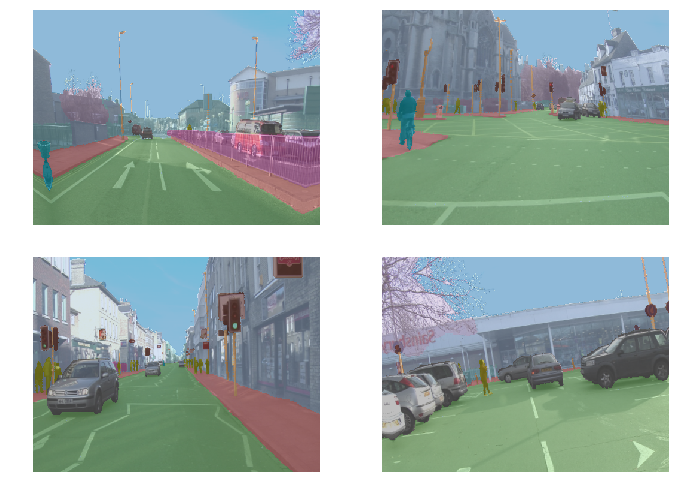

In [ ]:
data.show_batch(2, figsize=(10,7))

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-2

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

Total time: 03:41
epoch  train_loss  valid_loss  acc_camvid
1      1.454330    0.929582    0.803541    (00:33)
2      0.925828    0.852482    0.752774    (00:20)
3      0.662533    0.526695    0.843962    (00:20)
4      0.536184    0.517463    0.844439    (00:20)
5      0.464529    0.474884    0.853320    (00:20)
6      0.424862    0.417219    0.872210    (00:20)
7      0.402845    0.384075    0.884111    (00:20)
8      0.372008    0.294971    0.918785    (00:20)
9      0.348323    0.337362    0.895792    (00:20)
10     0.317101    0.293594    0.905015    (00:21)



In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

Total time: 03:02
epoch  train_loss  valid_loss  acc_camvid
1      1.168220    0.845053    0.787969    (00:27)
2      0.756652    0.639279    0.844674    (00:17)
3      0.608925    0.552053    0.866380    (00:17)
4      0.529037    0.557321    0.815035    (00:17)
5      0.461244    0.553054    0.857054    (00:17)
6      0.448754    0.397203    0.877370    (00:17)
7      0.418376    0.401803    0.884245    (00:17)
8      0.395860    0.348300    0.891183    (00:17)
9      0.371995    0.359320    0.884171    (00:17)
10     0.343473    0.262696    0.918478    (00:17)



In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

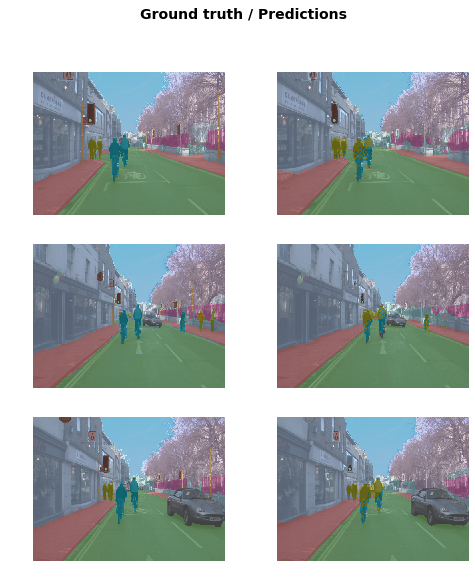

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

Total time: 03:43
epoch  train_loss  valid_loss  acc_camvid
1      0.286684    0.282926    0.907061    (00:18)
2      0.278658    0.284549    0.909271    (00:18)
3      0.272149    0.287311    0.912188    (00:18)
4      0.264540    0.319956    0.915928    (00:18)
5      0.256831    0.297458    0.911027    (00:18)
6      0.255743    0.268856    0.923269    (00:18)
7      0.251815    0.284328    0.915085    (00:18)
8      0.252744    0.275070    0.918130    (00:18)
9      0.248473    0.284428    0.923693    (00:18)
10     0.245056    0.281662    0.920232    (00:18)
11     0.238757    0.265186    0.925567    (00:18)
12     0.221390    0.252701    0.928842    (00:18)



In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=8

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


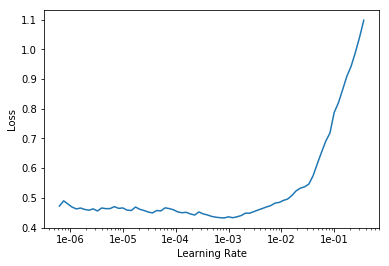

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

Total time: 03:14
epoch  train_loss  valid_loss  acc_camvid
1      0.201821    0.247604    0.930428    (00:28)
2      0.198176    0.256448    0.928860    (00:18)
3      0.197322    0.260491    0.928320    (00:18)
4      0.198210    0.241720    0.934403    (00:18)
5      0.200151    0.273925    0.922548    (00:18)
6      0.202652    0.274418    0.926767    (00:18)
7      0.200992    0.261334    0.928178    (00:18)
8      0.196631    0.249768    0.928857    (00:18)
9      0.191675    0.235492    0.936033    (00:18)
10     0.180158    0.242463    0.935826    (00:18)



In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/1000,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

Total time: 03:18
epoch  train_loss  valid_loss  acc_camvid
1      0.171148    0.243492    0.935147    (00:20)
2      0.169662    0.242512    0.935209    (00:19)
3      0.166831    0.241500    0.935996    (00:19)
4      0.164055    0.238851    0.936479    (00:19)
5      0.164808    0.249055    0.933963    (00:19)
6      0.161029    0.248002    0.934894    (00:19)
7      0.159466    0.243731    0.936218    (00:20)
8      0.158107    0.244575    0.935846    (00:19)
9      0.158217    0.243540    0.935600    (00:19)
10     0.157301    0.245301    0.935846    (00:19)



In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

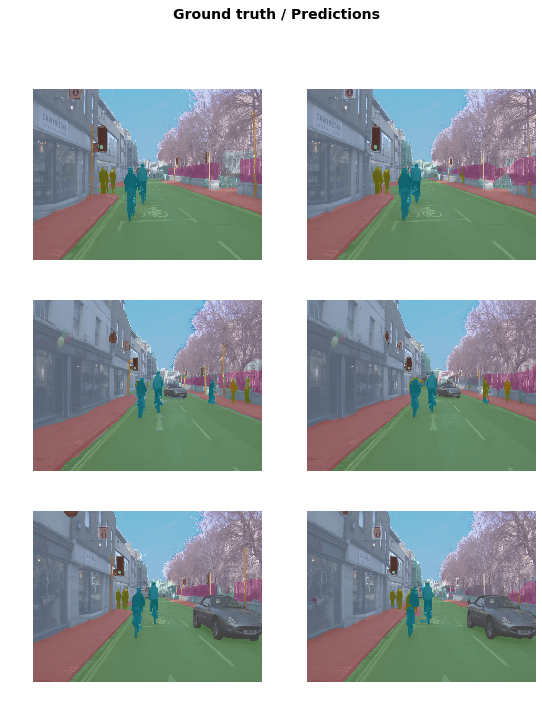

In [ ]:
learn.show_results(rows=3, figsize=(9,11))

## fin